# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [424]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
prevxRight = 0
prevxLeft = 0
prevslopeRight=0
prevslopeLeft=0

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


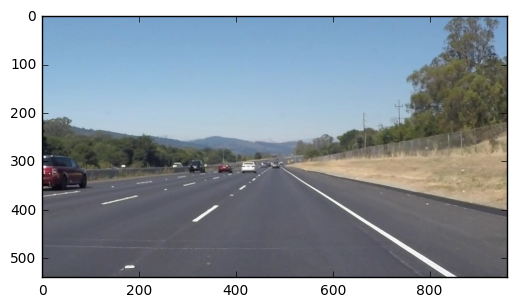

In [425]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [450]:
import math
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """    
    """ 
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y2 - slope * x2
            xLeft = 0 
            yLeft = intercept 
            xRight = 960 
            yRight = slope * 960 + intercept
            if slope < 0: #left line, negative slope
                #yMIN = slope * x1 + y1
                #yMAX = slope * x2 + y2
                cv2.line(img, (int(xLeft), int(yLeft)), (int(xRight), int(yRight)), color, thickness)
            elif slope > 0: #right line, positive slope
                cv2.line(img, (int(xLeft), int(yLeft)), (int(xRight), int(yRight)), color, thickness)
    """           
    
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    leftSlope = []
    rightSlope = []
    leftIntercept = []
    rightIntercept = []
    global prevxRight
    global prevxLeft
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1) 
            intercept = y2 - slope * x2
            if slope < -0.3 and slope > -0.8: #left line, negative slope
                rightX.append(x1)
                rightX.append(x2)
                rightY.append(y1)
                rightY.append(y2)
                rightSlope.append(slope)
                rightIntercept.append(intercept)
            elif slope < 0.8 and slope > 0.3:
                leftX.append(x1)
                leftX.append(x2)
                leftY.append(y1)
                leftY.append(y2)
                leftSlope.append(slope)
                leftIntercept.append(intercept)

    alpha = 0.001
    #left lane line
    avgSlope= np.mean(rightSlope)
    avgIntercept= np.mean(rightIntercept)
    xLeft = 130 
    yLeft = avgSlope * xLeft + avgIntercept 
    if(len(rightX)):
        if prevxRight == 0:
            xRight = max(rightX)#469#
        else:
            xRight = alpha*max(rightX) + (1-alpha)*prevxRight
        prevxRight = xRight
        yRight = avgSlope * xRight + avgIntercept
        cv2.line(img, (int(xLeft), int(yLeft)), (int(xRight), int(yRight)), color, thickness)

    #right lane line
    avgSlope= np.mean(leftSlope)
    avgIntercept= np.mean(leftIntercept)
    xLeft = 960 
    yLeft = avgSlope * xLeft + avgIntercept 
    if(len(leftX)):
        if prevxLeft == 0:
            xRight = min(leftX) #512 
        else:
            xRight = alpha*min(leftX) + (1-alpha)*prevxLeft #512 
        prevxLeft = xRight
        yRight = avgSlope * xRight + avgIntercept
        cv2.line(img, (int(xLeft), int(yLeft)), (int(xRight), int(yRight)), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [451]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

468.992005847
468.992013841
468.992013841
468.980021828
468.980021828
468.968041806
468.968041806
468.959073764
468.959073764
468.89411469


468.89411469
468.894220575


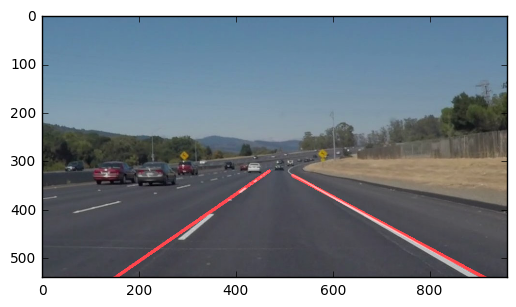

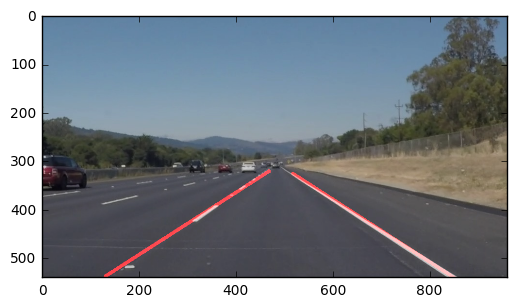

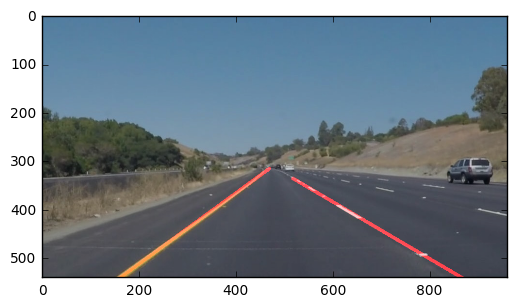

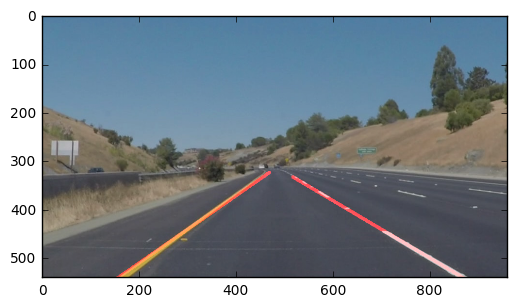

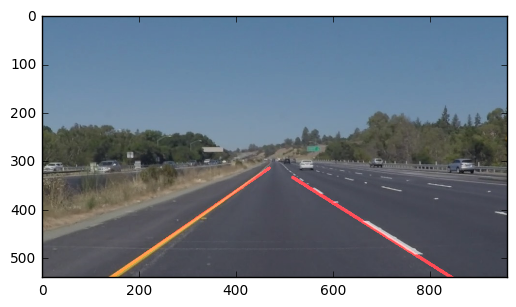

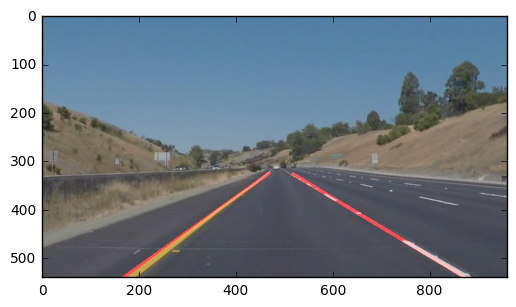

In [452]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def findLaneLines(image,kernel_size,low_threshold,high_threshold,vertices,rho,theta,threshold,min_line_len,max_line_gap):
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray,kernel_size)

    edges = canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges, vertices)
    line_image = np.copy(masked_edges)*0 # creating a blank to draw lines on
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Draw the lines on the edge image
    return weighted_img(line_image, image)
    
for f in os.listdir("test_images/"):
    image = mpimg.imread('test_images/'+f)
    #plt.figure()
    #plt.imshow(image) 
    imshape = image.shape
    vertices = np.array([[(130,540),(460, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    lines_edges = findLaneLines(image,5,50,150,\
                  vertices,10, np.pi/180, 15, 20,15)

    plt.figure()
    plt.imshow(lines_edges)
    #mpimg.imsave('test_images/'+'processed'+f,lines_edges)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [453]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [454]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    imshape = image.shape
    lines_edges = findLaneLines(image,5,50,150,\
                  vertices,10, np.pi/180, 10, 35,20)

    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [455]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

468.894220575
468.886326355
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  5%|▌         | 12/222 [00:00<00:01, 116.42it/s]

468.886326355
468.878440029
468.878440029
468.870561589
468.870561589
468.860691027
468.860691027
468.834830336
468.834830336
468.826995506
468.826995506
468.80616851
468.80616851
468.749362342
468.749362342
468.650612979
468.650612979
468.542962366
468.542962366
468.425419404
468.425419404
468.422993984
468.422993984
468.42057099
468.42057099
468.418150419
468.418150419
468.407732269
468.407732269
468.197324537
468.197324537
467.950127212
467.950127212
467.908177085
467.908177085
467.898268908
467.898268908
467.893370639
467.893370639
467.889477268
467.889477268
467.773587791
467.773587791
467.770814203




 11%|█▏        | 25/222 [00:00<00:01, 119.54it/s]

467.770814203
467.766043389
467.766043389
467.759277346




 17%|█▋        | 38/222 [00:00<00:01, 121.27it/s]

467.759277346
467.752518068
467.752518068
467.74576555
467.74576555
467.708019785
467.708019785
467.701311765
467.701311765
467.686610453
467.686610453
467.678923843
467.678923843
467.663244919
467.663244919
467.653581674
467.653581674
467.538928092
467.538928092
467.523389164
467.523389164
467.383865775
467.383865775
467.380481909
467.380481909
467.377101427
467.377101427
467.367724326
467.367724326
467.340356602
467.340356602
467.325016245
467.325016245
467.281691229
467.281691229
467.251409538
467.251409538
467.224158128
467.224158128
467.21193397
467.21193397
467.085722036


467.085722036
466.947636314
466.947636314
466.793688678




 22%|██▏       | 49/222 [00:00<00:01, 115.20it/s]

 27%|██▋       | 59/222 [00:00<00:01, 107.68it/s]

466.793688678
466.616894989
466.616894989
466.416278094
466.416278094
466.181861816
466.181861816
465.885679954
465.885679954
465.859794274
465.859794274
465.75993448
465.75993448
465.755174545
465.755174545
465.735419371
465.735419371
465.604683951
465.604683951
465.602079267
465.602079267
465.599477188
465.599477188
465.593877711
465.593877711
465.588283833
465.588283833
465.577695549
465.577695549
465.575117854
465.575117854
465.571542736


465.571542736
465.565971193
465.565971193
465.546405222
465.546405222



 31%|███       | 69/222 [00:00<00:01, 102.89it/s]

 36%|███▌      | 79/222 [00:00<00:01, 101.48it/s]


465.437858817
465.437858817
465.319420958
465.319420958
465.189101537
465.189101537
465.014912436
465.014912436
464.977897523
464.977897523
464.955919626
464.955919626
464.746963706
464.746963706
464.502216742
464.502216742
464.273714526
464.273714526
464.084440811
464.084440811
463.87435637
463.87435637
463.629482014




 40%|████      | 89/222 [00:00<00:01, 99.54it/s] 

 45%|████▌     | 100/222 [00:00<00:01, 100.07it/s]

463.629482014
463.625852532
463.625852532
463.622226679
463.622226679
463.619604453
463.619604453
463.520984848
463.520984848
463.509463863
463.509463863
463.392954399
463.392954399
463.381561445
463.381561445
463.240179884
463.240179884
463.081939704
463.081939704
462.904857764
462.904857764
462.700952906
462.700952906
462.462251953
462.462251953
462.461789701
462.461789701
462.442327912
462.442327912
462.444885584
462.444885584
462.442440698
462.442440698
462.445998258
462.445998258
462.448552259
462.448552259
462.448103707
462.448103707
462.448655603




 50%|████▉     | 110/222 [00:01<00:01, 98.85it/s] 

 55%|█████▍    | 121/222 [00:01<00:01, 99.78it/s]

462.448655603
462.449206948
462.449206948
462.444757741
462.444757741
462.437312983
462.437312983
462.43987567
462.43987567
462.437435794
462.437435794
462.433998359
462.433998359
462.43556436
462.43556436
462.433128796
462.433128796
462.333695667
462.333695667
462.225361971
462.225361971
462.213136609
462.213136609
462.204923473
462.204923473
462.203718549
462.203718549
462.203514831
462.203514831
462.207311316
462.207311316
462.212104005
462.212104005
462.215891901
462.215891901
462.219676009
462.219676009
462.223456333
462.223456333
462.222232876




 59%|█████▉    | 131/222 [00:01<00:00, 98.25it/s]

 64%|██████▎   | 141/222 [00:01<00:00, 97.30it/s]

462.222232876
462.227010643
462.227010643
462.231783633
462.231783633
462.237551849
462.237551849
462.243314297
462.243314297
462.236070983
462.236070983
462.239834912
462.239834912
462.242595077
462.242595077
462.242352482
462.242352482
462.24011013
462.24011013
462.234870019
462.234870019
462.230635149
462.230635149
462.234404514
462.234404514
462.23917011
462.23917011
462.24393094
462.24393094
462.222687009
462.222687009
462.224464322
462.224464322
462.079239857
462.079239857
462.067160618
462.067160618
462.071093457




 68%|██████▊   | 151/222 [00:01<00:00, 95.98it/s]

 73%|███████▎  | 161/222 [00:01<00:00, 95.13it/s]

462.071093457
462.066022363
462.066022363
462.068956341
462.068956341
462.072887385
462.072887385
462.076814497
462.076814497
462.081737683
462.081737683
461.986655945
461.986655945
461.989669289
461.989669289
461.98167962
461.98167962
461.98469794
461.98469794
461.987713242
461.987713242
461.985725529
461.985725529
461.812739804
461.812739804
461.815927064
461.815927064
461.822111137
461.822111137
461.822289026
461.822289026
461.828466737
461.828466737
461.83063827
461.83063827
461.834807632
461.834807632
461.744972824




 77%|███████▋  | 171/222 [00:01<00:00, 93.00it/s]

 82%|████████▏ | 181/222 [00:01<00:00, 92.88it/s]

461.744972824
461.751227851
461.751227851
461.760476623
461.760476623
461.628716147
461.628716147
461.631087431
461.631087431
461.616456343
461.616456343
461.590839887
461.590839887
461.592249047
461.592249047
461.600656798
461.600656798
461.596056141
461.596056141
461.603460085
461.603460085
461.609856625
461.609856625
461.617246768
461.617246768
461.617629521
461.617629521
461.620011892
461.620011892
461.62639188
461.62639188
461.626765488




 86%|████████▌ | 191/222 [00:01<00:00, 93.15it/s]

 91%|█████████ | 201/222 [00:02<00:00, 94.51it/s]

461.626765488
461.631138723
461.631138723
461.631507584
461.631507584
461.631876076
461.631876076
461.6362442
461.6362442
461.555607956
461.555607956
461.529052348
461.529052348
461.527523296
461.527523296
461.415995772
461.415995772
461.424579777
461.424579777
461.435155197
461.435155197
461.445720042
461.445720042
461.443274322
461.443274322
461.437831047
461.437831047
461.443393216
461.443393216
461.447949823
461.447949823
461.448501873
461.448501873
461.448053371
461.448053371
461.450605318
461.450605318
461.456154713
461.456154713
461.459698558




 95%|█████████▌| 211/222 [00:02<00:00, 93.29it/s]

100%|█████████▉| 221/222 [00:02<00:00, 95.19it/s]

461.459698558
461.458238859
461.458238859
461.462780621
461.462780621
461.46531784
461.46531784
461.273852522
461.273852522
461.27857867
461.27857867
461.281300091
461.281300091
461.285018791
461.285018791
461.289733772
461.289733772
461.298444038
461.298444038
461.307145594
461.307145594
461.204838449
461.204838449
461.20163361
461.20163361
461.205431977
461.205431977
461.213226545
461.213226545
461.221013318
461.221013318
461.227792305
461.227792305
461.233564512


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.09 s, sys: 2.06 s, total: 4.14 s
Wall time: 2.53 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [456]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [457]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

461.233564512
461.229330948
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

  2%|▏         | 12/682 [00:00<00:05, 113.95it/s]

461.229330948
461.225101617
461.225101617
461.219876515
461.219876515
461.214656639
461.214656639
461.206441982
461.206441982
461.20023554
461.20023554
461.198035305
461.198035305
461.195837269
461.195837269
461.193641432
461.193641432
461.184447791
461.184447791
461.177263343
461.177263343
461.17308608
461.17308608
461.159912993
461.159912993
461.14875308
461.14875308
461.134604327
461.134604327
461.118469723
461.118469723
461.110351253
461.110351253
461.081240902
461.081240902
461.071159661
461.071159661
461.060088502
461.060088502
461.048028413
461.048028413
461.017980385
461.017980385
460.999962404
460.999962404


460.947962442
460.947962442
460.923014479
460.923014479



  4%|▎         | 25/682 [00:00<00:05, 117.01it/s]

  6%|▌         | 38/682 [00:00<00:05, 120.05it/s]


460.864091465
460.864091465
460.841227373
460.841227373
460.811386146
460.811386146
460.73357476
460.73357476
460.712841185
460.712841185
460.686128344
460.686128344
460.592442216
460.592442216
460.561849773
460.561849773
460.528287924
460.528287924
460.501759636
460.501759636
460.463257876
460.463257876
460.423794618
460.423794618
460.388370824
460.388370824
460.313982453
460.313982453
460.18766847
460.18766847
460.140480802
460.140480802
460.087340321
460.087340321
459.914252981
459.914252981
459.861338728
459.861338728
459.797477389
459.797477389
459.750679912
459.750679912
459.715929232
459.715929232
459.635213302




  7%|▋         | 49/682 [00:00<00:05, 116.31it/s]

459.635213302
459.584578089
459.584578089
459.527993511




  9%|▊         | 59/682 [00:00<00:05, 106.65it/s]

459.527993511
459.484465518
459.484465518
459.245981052
459.245981052
459.189735071
459.189735071
459.128545336
459.128545336
459.060416791
459.060416791
458.965356374
458.965356374
458.872391017
458.872391017
458.823518626
458.823518626
458.798695108
458.798695108
458.748896413
458.748896413
458.703147516
458.703147516
458.644444369
458.644444369
458.610799924
458.610799924
458.571189124
458.571189124
458.537617935
458.537617935
458.504080317
458.504080317
458.331576237


458.331576237
458.307244661




 10%|▉         | 68/682 [00:00<00:06, 100.58it/s]

 11%|█▏        | 78/682 [00:00<00:06, 98.76it/s] 

458.307244661
458.288937416
458.288937416
458.241648479
458.241648479
458.17840683
458.17840683
458.166228423
458.166228423
458.154062195
458.154062195
458.125908133
458.125908133
458.083782225
458.083782225
458.023698442
458.023698442
458.016674744
458.016674744
458.008658069
458.008658069
457.939649411
457.939649411
457.930709762
457.930709762
457.908779052
457.908779052
457.847870273
457.847870273
457.830022403
457.830022403
457.76019238
457.76019238
457.745432188
457.745432188
457.715686756
457.715686756
457.668971069
457.668971069
457.639302098
457.639302098
457.624662796




 13%|█▎        | 89/682 [00:00<00:05, 100.03it/s]

 15%|█▍        | 100/682 [00:00<00:05, 99.76it/s]

457.624662796
457.604038133
457.604038133
457.534434095
457.534434095
457.517899661
457.517899661
457.462381761
457.462381761
457.465919379
457.465919379
457.46845346
457.46845346
457.467985007
457.467985007
457.471517022
457.471517022
457.447045504
457.447045504
457.448598459
457.448598459
457.449149861
457.449149861
457.415700711
457.415700711
457.41028501
457.41028501
457.412874725
457.412874725
457.40346185
457.40346185
457.365058388
457.365058388
457.36269333
457.36269333
457.353330637
457.353330637
457.311977306
457.311977306
457.302665329




 16%|█▌        | 110/682 [00:01<00:05, 97.96it/s]

 18%|█▊        | 120/682 [00:01<00:05, 96.89it/s]

457.302665329
457.269362663
457.269362663
457.274093301
457.274093301
457.278819207
457.278819207
457.280540388
457.280540388
457.263259848
457.263259848
457.256996588
457.256996588
457.255739591
457.255739591
457.260483852
457.260483852
457.256223368
457.256223368
457.262967145
457.262967145
457.268704177
457.268704177
457.196435473
457.196435473
457.202239038
457.202239038
457.208036799
457.208036799
457.171828762
457.171828762
457.158656933
457.158656933
457.115498276
457.115498276
457.115382778
457.115382778
457.113267395
457.113267395



 19%|█▉        | 130/682 [00:01<00:05, 95.88it/s]

 21%|██        | 140/682 [00:01<00:05, 95.82it/s]


457.049154128
457.049154128
457.035104974
457.035104974
457.038069869
457.038069869
456.917031799
456.917031799
456.926114767
456.926114767
456.932188652
456.932188652
456.942256464
456.942256464
456.947314207
456.947314207
456.952366893
456.952366893
456.960414526
456.960414526
456.918454112
456.918454112
456.911535657
456.911535657
456.921624122
456.921624122
456.930702498
456.930702498
456.939771795
456.939771795
456.944832023
456.944832023
456.950887191
456.950887191
456.955936304
456.955936304
456.963980368
456.963980368
456.973016387
456.973016387
456.979043371




 22%|██▏       | 150/682 [00:01<00:05, 95.54it/s]

 23%|██▎       | 160/682 [00:01<00:05, 95.74it/s]

456.979043371
456.987064328
456.987064328
456.996077263
456.996077263
457.000081186
457.000081186
456.987081105
456.987081105
456.997094024
456.997094024
457.00709693
457.00709693
457.018089833
457.018089833
457.029071743
457.029071743
457.047042671
457.047042671
457.064995629
457.064995629
457.069930633
457.069930633
457.079860702
457.079860702
457.100780842
457.100780842
457.117680061
457.117680061
457.138562381
457.138562381
457.147423818
457.147423818
457.158276395
457.158276395
457.168118118
457.168118118
457.13695
457.13695
457.13181305




 25%|██▍       | 170/682 [00:01<00:05, 95.77it/s]

 26%|██▋       | 180/682 [00:01<00:05, 96.02it/s]

457.13181305
457.110681237
457.110681237
457.119570556
457.119570556
457.125450985
457.125450985
457.080325534
457.080325534
457.012245209
457.012245209
457.005232963
457.005232963
457.011227731
457.011227731
457.018216503
457.018216503
456.905198286
456.905198286
456.881293088
456.881293088
456.845411795
456.845411795
456.734566383
456.734566383
456.705831817
456.705831817
456.667125985
456.667125985
456.655458859
456.655458859
456.5508034
456.5508034
456.554252597
456.554252597
456.563698344
456.563698344
456.579134646
456.579134646
456.587555511




 28%|██▊       | 190/682 [00:01<00:05, 96.90it/s]

 29%|██▉       | 200/682 [00:01<00:05, 95.56it/s]

456.587555511
456.590967956
456.590967956
456.598376988
456.598376988
456.605778611
456.605778611
456.613172832
456.613172832
456.625559659
456.625559659
456.6319341
456.6319341
456.638302165
456.638302165
456.521663863
456.521663863
456.454142199
456.454142199
456.465688057
456.465688057
456.470222369
456.470222369
456.474752147
456.474752147
456.479277395
456.479277395
456.471798117
456.471798117
456.441326319
456.441326319
456.445884993
456.445884993
456.455439108
456.455439108
456.465983669
456.465983669
456.465517685
456.465517685
456.476052167




 31%|███       | 210/682 [00:02<00:04, 95.50it/s]

 32%|███▏      | 220/682 [00:02<00:04, 96.38it/s]

456.476052167
456.474576115
456.474576115
456.470101539
456.470101539
456.478631438
456.478631438
456.481152806
456.481152806
456.337671653
456.337671653
456.340333982
456.340333982
456.341993648
456.341993648
456.342651654
456.342651654
456.228309002
456.228309002
456.227080693
456.227080693
456.226853613
456.226853613
456.229626759
456.229626759
456.231397132
456.231397132
456.191165735
456.191165735
456.192974569
456.192974569
456.151781595
456.151781595
456.155629813
456.155629813
456.158474183
456.158474183
456.156315709




 34%|███▎      | 230/682 [00:02<00:04, 94.51it/s]

 35%|███▌      | 240/682 [00:02<00:04, 95.74it/s]

456.156315709
456.159159394
456.159159394
456.162000234
456.162000234
456.163838234
456.163838234
456.166674396
456.166674396
456.170507721
456.170507721
456.174337214
456.174337214
456.161162876
456.161162876
456.162001713
456.162001713
456.128839712
456.128839712
456.128710872
456.128710872
456.129582161
456.129582161
456.111452579
456.111452579
456.070341126
456.070341126
456.058270785
456.058270785
455.992212515
455.992212515
455.972220302
455.972220302
455.961248082
455.961248082
455.859286834
455.859286834
455.862427547
455.862427547
455.863565119




 37%|███▋      | 250/682 [00:02<00:04, 96.30it/s]

 38%|███▊      | 260/682 [00:02<00:04, 96.13it/s]

455.863565119
455.862701554
455.862701554
455.850838853
455.850838853
455.846988014
455.846988014
455.842141026
455.842141026
455.845298885
455.845298885
455.846453586
455.846453586
455.850607132
455.850607132
455.846756525
455.846756525
455.846909769
455.846909769
455.849062859
455.849062859
455.853213796
455.853213796
455.855360582
455.855360582
455.848505222
455.848505222
455.835656716
455.835656716
455.83782106
455.83782106
455.829983239
455.829983239
455.833153255
455.833153255
455.837320102
455.837320102
455.841482782
455.841482782
455.845641299




 40%|███▉      | 270/682 [00:02<00:04, 94.87it/s]

 41%|████      | 280/682 [00:02<00:04, 95.30it/s]

455.845641299
455.849795658
455.849795658
455.853945862
455.853945862
455.856091916
455.856091916
455.861235824
455.861235824
455.866374589
455.866374589
455.871508214
455.871508214
455.876636706
455.876636706
455.891760069
455.891760069
455.896868309
455.896868309
455.900971441
455.900971441
455.906070469
455.906070469
455.910164399
455.910164399
455.914254234
455.914254234
455.91033998
455.91033998
455.92142964
455.92142964
455.924508211
455.924508211
455.923583702
455.923583702
455.925660119
455.925660119
455.927734459
455.927734459



 43%|████▎     | 290/682 [00:02<00:04, 94.64it/s]

 44%|████▍     | 300/682 [00:03<00:04, 95.38it/s]


455.929806724
455.929806724
455.870876917
455.870876917
455.78000604
455.78000604
455.799226034
455.799226034
455.817426808
455.817426808
455.818609382
455.818609382
455.819790772
455.819790772
455.819970981
455.819970981
455.81915101
455.81915101
455.820331859
455.820331859
455.821511528
455.821511528
455.820690016
455.820690016
455.821869326
455.821869326
455.819047457
455.819047457
455.809228409
455.809228409
455.807419181
455.807419181
455.808611762
455.808611762
455.79780315
455.79780315
455.779005347
455.779005347
455.778226341




 45%|████▌     | 310/682 [00:03<00:03, 94.28it/s]

 47%|████▋     | 320/682 [00:03<00:03, 95.78it/s]

455.778226341
455.777448115
455.777448115
455.747670667
455.747670667
455.745922996
455.745922996
455.733177073
455.733177073
455.727443896
455.727443896
455.715716452
455.715716452
455.715000736
455.715000736
455.712285735
455.712285735
455.689573449
455.689573449
455.684883876
455.684883876
455.644198992
455.644198992
455.642554793
455.642554793
455.612912238
455.612912238
455.594299326
455.594299326
455.590705027
455.590705027
455.588114322
455.588114322
455.583526207
455.583526207
455.579942681
455.579942681
455.577362738




 48%|████▊     | 330/682 [00:03<00:03, 91.61it/s]

 50%|████▉     | 340/682 [00:03<00:03, 92.06it/s]

455.577362738
455.517785376
455.517785376
455.51126759
455.51126759
455.507756323
455.507756323
455.503248566
455.503248566
455.499745318
455.499745318
455.493245573
455.493245573
455.487752327
455.487752327
455.484264575
455.484264575
455.46178031
455.46178031
455.45831853
455.45831853
455.454860211
455.454860211
455.445405351
455.445405351
455.437959946
455.437959946
455.365521986
455.365521986
455.357156464
455.357156464
455.353799307
455.353799307
455.341445508
455.341445508
455.336104062




 51%|█████▏    | 350/682 [00:03<00:03, 92.79it/s]

 53%|█████▎    | 360/682 [00:03<00:03, 94.65it/s]

455.336104062
455.327767958
455.327767958
455.31844019
455.31844019
455.31012175
455.31012175
455.306811628
455.306811628
455.267504817
455.267504817
455.252237312
455.252237312
455.195985075
455.195985075
455.18078909
455.18078909
455.177608301
455.177608301
455.167430692
455.167430692
455.156263262
455.156263262
455.147106998
455.147106998
455.132959891
455.132959891
455.083826931
455.083826931
455.072743104
455.072743104
455.054670361
455.054670361
455.018615691
455.018615691
454.964597075
454.964597075
454.842632478
454.842632478
454.784789846




 54%|█████▍    | 370/682 [00:03<00:03, 94.95it/s]

 56%|█████▌    | 380/682 [00:03<00:03, 95.77it/s]

454.784789846
454.744005056
454.744005056
454.721261051
454.721261051
454.71253979
454.71253979
454.67882725
454.67882725
454.666148423
454.666148423
454.657482274
454.657482274
454.624824792
454.624824792
454.580199967
454.580199967
454.568619767
454.568619767
454.554051148
454.554051148
454.545497096
454.545497096
454.536951599
454.536951599
454.486414648
454.486414648
454.474928233
454.474928233
454.460453305
454.460453305
454.436992852
454.436992852
454.413555859
454.413555859
454.408142303
454.408142303
454.357734161
454.357734161
454.353376426




 57%|█████▋    | 390/682 [00:04<00:03, 94.75it/s]

 59%|█████▉    | 401/682 [00:04<00:02, 96.74it/s]

454.353376426
454.34802305
454.34802305
454.288675027
454.288675027
454.280386352
454.280386352
454.209105965
454.209105965
454.08689686
454.08689686
454.084809963
454.084809963
454.081725153
454.081725153
454.069643428
454.069643428
454.070573784
454.070573784
454.06850321
454.06850321
453.998434707
453.998434707
453.997436272
453.997436272
453.959438836
453.959438836
453.957479397
453.957479397
453.951521918
453.951521918
453.952570396
453.952570396
453.954617826
453.954617826
453.951663208
453.951663208
453.915711545
453.915711545
453.911795833




 60%|██████    | 411/682 [00:04<00:02, 96.19it/s]

 62%|██████▏   | 421/682 [00:04<00:02, 95.93it/s]

453.911795833
453.913884037
453.913884037
453.917970153
453.917970153
453.921052183
453.921052183
453.924131131
453.924131131
453.928207
453.928207
453.927278793
453.927278793
453.865351514
453.865351514
453.868486162
453.868486162
453.867617676
453.867617676
453.864750059
453.864750059
453.855885308
453.855885308
453.856029423
453.856029423
453.863173394
453.863173394
453.87031022
453.87031022
453.67943991
453.67943991
453.58676047
453.58676047
453.59517371
453.59517371
453.600578536
453.600578536
453.605977958
453.605977958
453.61337198




 63%|██████▎   | 431/682 [00:04<00:02, 95.81it/s]

453.61337198
453.620758608
453.620758608
453.507137849
453.507137849
453.435630711
453.435630711
453.27219508
453.27219508
453.280922885
453.280922885
453.288641962
453.288641962
453.28735332
453.28735332
453.279065967
453.279065967
453.283786901
453.283786901
453.272503114
453.272503114
453.280230611
453.280230611
453.257950381
453.257950381
453.21269243
453.21269243
453.213479738
453.213479738
453.158266258
453.158266258
453.156107992
453.156107992
453.154951884




 65%|██████▍   | 441/682 [00:04<00:02, 91.76it/s]

453.154951884
453.152796932




 66%|██████▌   | 451/682 [00:04<00:02, 90.40it/s]

453.152796932
453.124644135
453.124644135
453.125519491
453.125519491
453.127393971
453.127393971
453.129266577
453.129266577
453.125137311
453.125137311
453.120012173
453.120012173
453.116892161
453.116892161
453.118775269
453.118775269
453.114656494
453.114656494
453.108541837
453.108541837
453.106433296
453.106433296
453.038326862
453.038326862
453.000288535
453.000288535
452.996288247
452.996288247
452.995291959
452.995291959
453.001296667
453.001296667
453.00629537


453.00629537
453.016289075




 68%|██████▊   | 461/682 [00:04<00:02, 89.23it/s]

 69%|██████▉   | 470/682 [00:04<00:02, 86.83it/s]

453.016289075
452.950272786
452.950272786
452.899322513
452.899322513
452.90742319
452.90742319
452.915515767
452.915515767
452.908600251
452.908600251
452.920691651
452.920691651
452.926770959
452.926770959
452.907844188
452.907844188
452.918936344
452.918936344
452.926017408
452.926017408
452.93809139
452.93809139
452.943153299
452.943153299
452.925210146
452.925210146
452.844284936
452.844284936
452.853440651
452.853440651
452.86558721
452.86558721
452.829721623




 70%|███████   | 479/682 [00:04<00:02, 84.89it/s]

 72%|███████▏  | 489/682 [00:05<00:02, 87.87it/s]

452.829721623
452.839891901
452.839891901
452.849052009
452.849052009
452.793202957
452.793202957
452.805409754
452.805409754
452.818604345
452.818604345
452.83178574
452.83178574
452.844953954
452.844953954
452.858109001
452.858109001
452.871250892
452.871250892
452.865379641
452.865379641
452.870514261
452.870514261
452.869643747
452.869643747
452.834774103
452.834774103
452.842939329
452.842939329
452.85109639
452.85109639
452.865245293
452.865245293
452.877380048
452.877380048
452.891502668
452.891502668
452.845611165




 73%|███████▎  | 499/682 [00:05<00:02, 89.16it/s]

 75%|███████▍  | 509/682 [00:05<00:01, 91.75it/s]

452.845611165
452.858765554
452.858765554
452.867906788
452.867906788
452.877038882
452.877038882
452.886161843
452.886161843
452.896275681
452.896275681
452.910379405
452.910379405
452.927469026
452.927469026
452.940541557
452.940541557
452.955601015
452.955601015
452.966645414
452.966645414
452.961678769
452.961678769
452.97671709
452.97671709
452.986740373
452.986740373
452.996753633
452.996753633
453.009756879
453.009756879
453.013747122
453.013747122
453.036733375
453.036733375
453.002696642
453.002696642
453.014693945




 76%|███████▌  | 519/682 [00:05<00:01, 92.24it/s]

 78%|███████▊  | 529/682 [00:05<00:01, 93.02it/s]

453.014693945
453.031679251
453.031679251
453.040647572
453.040647572
453.056606924
453.056606924
453.069550317
453.069550317
453.081480767
453.081480767
453.099399286
453.099399286
453.116299887
453.116299887
453.125183587
453.125183587
453.143058403
453.143058403
453.162915345
453.162915345
453.18275243
453.18275243
453.187569677
453.187569677
453.207382108
453.207382108
453.223174725
453.223174725
453.240951551
453.240951551
453.225710599
453.225710599
453.244484889
453.244484889
453.264240404
453.264240404
453.282976163
453.282976163
453.301693187




 79%|███████▉  | 539/682 [00:05<00:01, 93.00it/s]

 80%|████████  | 549/682 [00:05<00:01, 94.93it/s]

453.301693187
453.320391494
453.320391494
453.339071102
453.339071102
453.323732031
453.323732031
453.343408299
453.343408299
453.362064891
453.362064891
453.379702826
453.379702826
453.397323123
453.397323123
453.4079258
453.4079258
453.424517874
453.424517874
453.436093357
453.436093357
453.451657263
453.451657263
453.468205606
453.468205606
453.4537374
453.4537374
453.468283663
453.468283663
453.470815379
453.470815379
453.486344564
453.486344564
453.499858219
453.499858219
453.508358361
453.508358361
453.516850003
453.516850003
453.533333153
453.533333153
453.55079982




 82%|████████▏ | 560/682 [00:05<00:01, 97.38it/s]

 84%|████████▎ | 570/682 [00:05<00:01, 96.27it/s]

453.55079982
453.56024902
453.56024902
453.575688771
453.575688771
453.576113082
453.576113082
453.519536969
453.519536969
453.506017432
453.506017432
453.521511414
453.521511414
453.532989903
453.532989903
453.510456913
453.510456913
453.519946456
453.519946456
453.41942651
453.41942651
453.436007083
453.436007083
453.436571076
453.436571076
453.405134505
453.405134505
453.420729371
453.420729371
453.359308641
453.359308641
453.376949333
453.376949333
453.393572383
453.393572383
453.383178811
453.383178811
453.222795632
453.222795632



 85%|████████▌ | 580/682 [00:06<00:01, 95.63it/s]

 87%|████████▋ | 590/682 [00:06<00:00, 96.20it/s]


453.241572836
453.241572836
453.258331264
453.258331264
453.274072932
453.274072932
453.285798859
453.285798859
453.296513061
453.296513061
453.311216547
453.311216547
453.327905331
453.327905331
453.345577426
453.345577426
453.353231848
453.353231848
453.369878616
453.369878616
453.388508738
453.388508738
453.407120229
453.407120229
453.423713109
453.423713109
453.420289396
453.420289396
453.437869106
453.437869106
453.457431237
453.457431237
453.443973806
453.443973806
453.460529832
453.460529832
453.439069302
453.439069302
453.448630233
453.448630233
453.455181603




 88%|████████▊ | 600/682 [00:06<00:00, 95.78it/s]

 89%|████████▉ | 610/682 [00:06<00:00, 94.52it/s]

453.455181603
453.399726421
453.399726421
453.419326695
453.419326695
453.438907368
453.438907368
453.456468461
453.456468461
453.370011992
453.370011992
453.38864198
453.38864198
453.405253338
453.405253338
453.418848085
453.418848085
453.424429237
453.424429237
453.431004808
453.431004808
453.425573803
453.425573803
453.433148229
453.433148229
453.446715081
453.446715081
453.456268366
453.456268366
453.467812097
453.467812097
453.447344285
453.447344285
453.429896941
453.429896941
453.428467044
453.428467044
453.347038577




 91%|█████████ | 620/682 [00:06<00:00, 93.96it/s]

 92%|█████████▏| 630/682 [00:06<00:00, 94.50it/s]

453.347038577
453.361691538
453.361691538
453.139329847
453.139329847
453.118190517
453.118190517
453.078072326
453.078072326
453.064994254
453.064994254
453.07392926
453.07392926
453.063855331
453.063855331
453.044791475
453.044791475
452.950746684
452.950746684
452.921795937
452.921795937
452.776874141
452.776874141
452.763097267
452.763097267
452.70833417
452.70833417
452.722625836
452.722625836
452.53590321
452.53590321
452.545367307
452.545367307
452.519821939




 94%|█████████▍| 640/682 [00:06<00:00, 94.25it/s]

 95%|█████████▌| 650/682 [00:06<00:00, 93.46it/s]

452.519821939
452.529302117
452.529302117
452.536772815
452.536772815
452.545236042
452.545236042
452.546690806
452.546690806
452.556144115
452.556144115
452.550587971
452.550587971
452.558037383
452.558037383
452.565479346
452.565479346
452.576913867
452.576913867
452.587336953
452.587336953
452.592749616
452.592749616
452.591156866
452.591156866
452.537565709
452.537565709
452.547028144
452.547028144
452.525481116
452.525481116
452.534955634
452.534955634
452.537420679
452.537420679
452.523883258
452.523883258
452.336359375




 97%|█████████▋| 660/682 [00:06<00:00, 93.38it/s]

 98%|█████████▊| 670/682 [00:07<00:00, 93.95it/s]

452.336359375
452.345023015
452.345023015
452.325677992
452.325677992
452.269352314
452.269352314
452.276082962
452.276082962
452.284806879
452.284806879
452.290522072
452.290522072
452.29823155
452.29823155
452.306933319
452.306933319
452.314626385
452.314626385
452.322311759
452.322311759
452.327989447
452.327989447
452.335661458
452.335661458
452.343325796
452.343325796
452.35098247
452.35098247
452.358631488
452.358631488
452.339272857
452.339272857
452.334933584
452.334933584
452.34059865
452.34059865
452.302258051
452.302258051




100%|█████████▉| 680/682 [00:07<00:00, 94.98it/s]

100%|█████████▉| 681/682 [00:07<00:00, 95.59it/s]

452.308955793
452.308955793
452.314646838
452.314646838
452.320332191
452.320332191
452.326011859
452.326011859
452.327685847
452.327685847
452.331358161
452.331358161
452.335026803
452.335026803
452.338691776
452.338691776
452.341353084
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6.68 s, sys: 5.87 s, total: 12.5 s
Wall time: 7.43 s


In [458]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [459]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

452.341353084
452.588011731
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  3%|▎         | 7/251 [00:00<00:03, 65.25it/s]

452.588011731
452.834423719
452.834423719
453.078589296
453.078589296
453.324510706
453.324510706
453.524186196
453.524186196
453.753662009
453.753662009
453.999908347
453.999908347
454.243908439
454.243908439
454.460664531
454.460664531
454.677203866
454.677203866
454.910526662
454.910526662
455.152616136
455.152616136
455.382463519


455.382463519
455.603081056
455.603081056
455.799477975




  6%|▌         | 15/251 [00:00<00:03, 66.88it/s]

  9%|▉         | 22/251 [00:00<00:03, 67.59it/s]

455.799477975
456.044678497
456.044678497
456.289633818
456.289633818
456.510344185
456.510344185
456.73183384
456.73183384
456.891102007
456.891102007
457.051210905
457.051210905
457.277159694
457.277159694
457.522882534
457.522882534
457.703359651
457.703359651
457.873656292
457.873656292
458.094782635
458.094782635
458.312687853
458.312687853
458.537375165
458.537375165
458.76283779
458.76283779



 12%|█▏        | 29/251 [00:00<00:03, 68.18it/s]

 14%|█▍        | 36/251 [00:00<00:03, 67.91it/s]


458.995074952
458.995074952
459.168079877
459.168079877
459.407911797
459.407911797
459.648503885
459.648503885
459.893855381
459.893855381
460.131961526
460.131961526
460.369829565
460.369829565
460.601459735
460.601459735
460.828858275
460.828858275
461.063029417
461.063029417
461.301966388
461.301966388
461.531664421


461.531664421
461.745132757
461.745132757
461.979387624
461.979387624



 17%|█▋        | 43/251 [00:00<00:03, 66.13it/s]

 20%|█▉        | 49/251 [00:00<00:03, 64.12it/s]


462.201408236
462.201408236
462.434206828
462.434206828
462.672772621
462.672772621
462.911099849
462.911099849
463.154188749
463.154188749
463.39203456
463.39203456
463.613642526
463.613642526
463.843028883
463.843028883
464.087185854
464.087185854
464.314098668


464.314098668
464.55078457
464.55078457
464.797233785
464.797233785
465.029436551




 22%|██▏       | 55/251 [00:00<00:03, 60.00it/s]

 24%|██▍       | 61/251 [00:00<00:03, 55.06it/s]

465.029436551
465.253407115
465.253407115
465.485153708
465.485153708
465.727668554
465.727668554
465.932940885
465.932940885
466.158007944
466.158007944
466.368849937
466.368849937
466.590481087


466.590481087
466.798890605
466.798890605
467.024091715
467.024091715
467.222067623




 27%|██▋       | 67/251 [00:01<00:03, 51.23it/s]

467.222067623
467.424845556
467.424845556
467.63242071
467.63242071
467.856788289
467.856788289
468.049931501
468.049931501
468.259881569
468.259881569
468.455621688
468.455621688



 29%|██▉       | 73/251 [00:01<00:03, 49.84it/s]


468.658166066
468.658166066
468.8635079
468.8635079
469.079644392
469.079644392
469.292564748




 31%|███       | 78/251 [00:01<00:03, 48.35it/s]

469.292564748
469.502272183
469.502272183
469.704769911
469.704769911
469.931065141
469.931065141
470.147134076
470.147134076
470.327986942
470.327986942
470.494658955
470.494658955



 33%|███▎      | 83/251 [00:01<00:03, 46.96it/s]


470.718164296
470.718164296
470.948446132
470.948446132
471.129497685




 35%|███▌      | 88/251 [00:01<00:03, 46.41it/s]

471.129497685
471.324368188
471.324368188
471.45904382
471.45904382
471.669584776
471.669584776
471.894915191
471.894915191
472.122020276
472.122020276
472.348898256
472.348898256
472.521549357
472.521549357
472.757027808




 37%|███▋      | 93/251 [00:01<00:03, 45.70it/s]

472.757027808
472.98727078




 39%|███▉      | 98/251 [00:01<00:03, 45.77it/s]

472.98727078
473.224283509
473.224283509
473.452059226
473.452059226
473.645607167
473.645607167
473.863961559
473.863961559
474.090097598
474.090097598
474.3050075
474.3050075
474.482702493
474.482702493
474.67421979
474.67421979
475.048545571




 41%|████      | 103/251 [00:01<00:03, 46.72it/s]

475.048545571
475.348497025




 43%|████▎     | 108/251 [00:02<00:03, 46.70it/s]

475.348497025
475.525148528
475.525148528
475.507623379
475.507623379
475.630115756
475.630115756
475.80348564
475.80348564
475.911682155
475.911682155
476.121770472
476.121770472
476.251648702
476.251648702
476.416397053
476.416397053
476.606980656




 45%|████▌     | 113/251 [00:02<00:02, 46.80it/s]

476.606980656
476.763373676




 47%|████▋     | 118/251 [00:02<00:02, 47.00it/s]

476.763373676
476.889610302
476.889610302
477.085720692
477.085720692
477.238634971
477.238634971
477.356396336
477.356396336
477.51803994
477.51803994
477.6115219
477.6115219
477.699910378
477.699910378
477.752210467
477.752210467
477.953458257




 49%|████▉     | 123/251 [00:02<00:02, 46.89it/s]

477.953458257
478.042504799




 51%|█████     | 128/251 [00:02<00:02, 45.93it/s]

478.042504799
478.216462294
478.216462294
478.300245832
478.300245832
478.498945586
478.498945586
478.69044664
478.69044664
478.881756193
478.881756193
479.014874437
479.014874437
479.210859563
479.210859563
479.395648703


479.395648703
479.556253055




 53%|█████▎    | 133/251 [00:02<00:02, 44.93it/s]

 55%|█████▍    | 138/251 [00:02<00:02, 44.57it/s]

479.556253055
479.648696802
479.648696802
479.858048105
479.858048105
480.033190057
480.033190057
480.225156867
480.225156867
480.38693171
480.38693171
480.600544778
480.600544778
480.810944233
480.810944233
480.915133289
480.915133289
481.127218156




 57%|█████▋    | 143/251 [00:02<00:02, 43.24it/s]

 59%|█████▉    | 148/251 [00:02<00:02, 44.14it/s]

481.127218156
481.283090938
481.283090938
481.410807847
481.410807847
481.551397039
481.551397039
481.814845642
481.814845642
481.979030796
481.979030796
482.187051765
482.187051765
482.406864714
482.406864714
482.558457849
482.558457849
482.714899391
482.714899391



 61%|██████    | 153/251 [00:03<00:02, 44.72it/s]

 63%|██████▎   | 158/251 [00:03<00:02, 46.08it/s]


482.891184492
482.891184492
483.111293307
483.111293307
483.321182014
483.321182014
483.463860832
483.463860832
483.671396971
483.671396971
483.890725574
483.890725574
484.058834848
484.058834848
484.197776014
484.197776014
484.389578238
484.389578238
484.594188659




 65%|██████▍   | 163/251 [00:03<00:01, 46.82it/s]

 67%|██████▋   | 168/251 [00:03<00:01, 45.07it/s]

484.594188659
484.785594471
484.785594471
484.988808876
484.988808876
485.200820067
485.200820067
485.412619247
485.412619247
485.611206628
485.611206628
485.831595421
485.831595421
486.039763826
486.039763826
486.250724062
486.250724062
486.421473338
486.421473338



 69%|██████▉   | 173/251 [00:03<00:01, 44.58it/s]


486.644051865
486.644051865
486.854407813
486.854407813
487.073553405
487.073553405
487.271479852
487.271479852
487.482208372
487.482208372
487.656726163
487.656726163
487.854069437
487.854069437
488.035215368
488.035215368
488.182180152




 71%|███████   | 178/251 [00:03<00:01, 45.22it/s]

 73%|███████▎  | 183/251 [00:03<00:01, 44.59it/s]

488.182180152
488.382997972
488.382997972
488.530614974
488.530614974
488.734084359
488.734084359
488.938350275
488.938350275
489.092411925
489.092411925
489.243319513
489.243319513
489.413076193
489.413076193
489.599663117
489.599663117
489.806063454




 75%|███████▍  | 188/251 [00:03<00:01, 43.33it/s]

 77%|███████▋  | 193/251 [00:03<00:01, 42.41it/s]

489.806063454
489.98025739
489.98025739
490.182277133
490.182277133
490.371094856
490.371094856
490.546723761
490.546723761
490.729177037
490.729177037
490.92044786
490.92044786
491.111527412
491.111527412
491.303415885
491.303415885
491.497112469




 79%|███████▉  | 198/251 [00:04<00:01, 41.90it/s]

 81%|████████  | 203/251 [00:04<00:01, 42.18it/s]

491.497112469
491.677615357
491.677615357
491.855937741
491.855937741
492.034081804
492.034081804
492.210047722
492.210047722
492.400837674
492.400837674
492.589436836
492.589436836
492.7868474
492.7868474
492.897060552
492.897060552
493.092163492




 83%|████████▎ | 208/251 [00:04<00:00, 43.08it/s]

 85%|████████▌ | 214/251 [00:04<00:00, 45.10it/s]

493.092163492
493.234071328
493.234071328
493.426837257
493.426837257
493.62641042
493.62641042
493.824784009
493.824784009
494.023959225
494.023959225
494.219935266
494.219935266
494.414715331
494.414715331
494.602300615
494.602300615
494.790698315
494.790698315
494.984907616




 87%|████████▋ | 219/251 [00:04<00:00, 45.86it/s]

 90%|████████▉ | 225/251 [00:04<00:00, 47.87it/s]

494.984907616
495.161922709
495.161922709
495.344760786
495.344760786
495.525416025
495.525416025
495.703890609
495.703890609
495.893186719
495.893186719
496.090293532
496.090293532
496.273203238
496.273203238
496.468930035
496.468930035
496.521461105
496.521461105
496.655939644
496.655939644
496.839283704




 92%|█████████▏| 231/251 [00:04<00:00, 48.93it/s]

 94%|█████████▍| 237/251 [00:04<00:00, 49.87it/s]

496.839283704
497.024444421
497.024444421
497.157419976
497.157419976
497.348262556
497.348262556
497.478914294
497.478914294
497.670435379
497.670435379
497.860764944
497.860764944
497.982904179
497.982904179
498.162921275
498.162921275
498.250758354
498.250758354
498.419507595
498.419507595
498.609088088




 97%|█████████▋| 243/251 [00:04<00:00, 50.40it/s]

498.609088088
498.799479
498.799479
498.985679521
498.985679521
499.174693841
499.174693841
499.353519147
499.353519147
499.548165628
499.548165628
499.728617462
499.728617462
499.890888845
499.890888845
500.074997956
500.074997956
500.260922958
500.260922958
500.452662035
500.452662035
500.621209373




 99%|█████████▉| 249/251 [00:05<00:00, 51.05it/s]

100%|██████████| 251/251 [00:05<00:00, 49.09it/s]

500.621209373
500.749588164
500.749588164
500.928838576
500.928838576
501.120909737
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4.68 s, sys: 2.31 s, total: 6.99 s
Wall time: 5.76 s


In [460]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))